---
title: "Writing Stable Diffusion from Scratch 12"
reading-time: 
date: "2023-4-6"
categories: [fastaipart2,Stable-Diffusion]
---

**All** credits goes to fast.ai <br> All mistakes are mine.<br>
You should know and practice following after this blog post : <br>
1- Way better Learner <br>
2- Learner finder 

In [1]:
!pip install -Uqq git+https://github.com/fastai/course22p2


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 8.0 MB/s eta 0:0

In [2]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [3]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
logging.disable(logging.WARNING)

## Learner

Hi there, and welcome to lesson 16, where we are working on building our first flexible trading framework, the learner. And I've got some very good news, which is that I have thought of a way of doing it a little bit more gradually and simply actually than last time. So that should that should make things a bit easier. So we're going to take it a bit more step by step. So we're working in the 9 learner notebook today and we've seen already this, this basic callbacks learner And so the idea is that this learner, all right, this is why we saw no, we've seen so far this learner, which wasn't flexible at all, but it had all the basic pieces, which is we've got a fit method. We had coding that we can only calculate accuracy and average loss. We're had coding, we're putting things on a default device, hard coding, a single learning rate. But the basic idea is here we go through each epoch and call one epoch to to train or evaluate depending on this flag, and then we loop through each batch and the dataloader and one batch is going to grab the x and y parts of the batch, call the model, call the loss function. And if we're training, do the backward pass and then print out well, calculate the statistics for our accuracy and then at the end of the epoch, print that out. So it wasn't very flexible, but it did do something. So that's good. 


In [6]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [8]:
bs = 1024
tds = dsd.with_transform(transformi)

In [9]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

 So what we're going to do now is we're going to do as an intermediate step, we're going to look at a but I'm calling a basic callback, learner, And it actually has nearly all the functionality of the full thing, the way we're going to after we look at this basic callback learner, we're then going to after creating some callbacks and metrics, we're going to look at something called the Flexible learner So let's go step by step. So the basic callbacks,learner looks very similar to the previous. learner It, it's got a fit function which is going to go through each epoch calling one epoch with training on and then training off, and then one epoch. We'll go through each batch and call one batch and one batch will call the model the loss function. And if we're training, it will do the backward step. So that's all pretty similar. But there's a few more things going on here. For example, if we have a look at fit, you'll see that after creating the optimizer, so called self.opt_func. So opt func here defaults to SGD. So we instantiate an object passing in our models parameters and the requested learning rate. And then before we start looping through one epoch at a time. Now we've set epochs here. We first of all call self.callback and passing in before fit. Now what does that do? Self.callback is here and it takes a method name. So in this case it's before fit and it calls a function called run callbacks. It passes in a list of our callbacks and the method name in this case before fit. So Run callbacks is something that's going to go for each callback and it's going to sort them in order of their order attribute. And so there's a base class of callbacks which has an order of zero. So our callbacks are all going to have the same order of zero in which you ask otherwise. So here's an example of a callback. So before we look at how callbacks work, let's just let's just run a callback so we can create a ridiculously simple callback code completion callback, which before we start fitting a new model it will set its count attribute to zero , after each batch it will increment that after completing fitting process, it will print out how many batches we've done. So before we even train the model, we could just run manually before fit ,after_batch and ,after_fit using this run_cbs. And you can see it's ended up saying completed one batches. So what did that do? So it went through each of the cbs. In this list there's only one. So it's going to look at the one CB and it's going to try to use getattr to find an attribute with this name, which is before_fit. So if we try that manually. So this is the kind of thing I want you to do if you find anything difficult to understand is do it all manually. So create a callback, set it cbs zero, just like you're doing in a loop, right? And then find out what happens if we call this and pass in this and you'll say it's returned a method. And then what happens to that method? It gets called. So let's try calling it there. Yeah. So that's what happened when we call the before_fit, which doesn't do anything very interesting. But if we then call after_batch and then we call after_fit, there it is. Right. So yeah, make sure you don't just run code willy nilly, but understand it by experimenting with it. And I don't always experiment with it myself in these classes. Often I'm leaving that to you, but sometimes I'm trying to give you a sense of how I would experiment with code if I was learning it. So then having done that, I would then go ahead and delete those cells. But you can say I'm using this interactive notebook environment to to explore and learn and understand. And so now we've got and if I haven't created a simple example of something to make it really easy to understand, you should do that right? Then just use what I've already created or what somebody else has already created. So we've now got something that works totally independently. We can see how it works. This is what a callback does. So a callback is something which we'll look at a class, a callback as a class where you can define one or more of before, after fit, before, after batch, and before after epoch. So it's going to go through and run all the callbacks that have a before fit method before we start fitting. Then it'll go through each epoch and call one epoch with training and one epoch with evaluation. And then when that's all done, it will call after it callbacks and one epoch well before it starts on enumerating through the batches. It will call before epoch, and when it's done, it will call after_epoch. The other thing you'll notice is that there's a try, except immediately before every before method and immediately after every after method there's a try and there's an except and each one has a different thing to look for. Cancel fit exception, cancel a epoch exception and cancel that exception. So here's the bit which goes through each batch calls before batch processes, the batch calls after batch, and if there's an exception that says type cancel batch exception, it gets ignored. So what's that for? So the reason we have this is that any of our callbacks code call could raise any one of these three exceptions to say, I don't want to do this batch, please. So maybe I'll look an example of that in a moment so we can now train with this. So let's call create a little get model function that creates a sequential model with just some linear layers. And then we'll probably didn't run all those and then we'll call fit. And it's not telling us anything interesting because the only callback we added was the completion callback. That's fine. It's, it's training, it's doing something and we now have a train model, just didn't print out any metrics. And I think that we don't have any callbacks for that. But that's the basic idea. So we could create a maybe we could call it a single batch callback, which after batch, after a single batch, it raises a cancel fit the exception. So that's a pretty I mean, I suppose that could be kind of useful actually, if you want to just run one batch tomorrow to make sure it works. So we could try that. Yeah. So now we're going to add to our list of callbacks. The single batch callback. Let's try it. And in fact, you know, we probably want this. Let's just have a think here. Oh, that's fine. 


In [10]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [11]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [12]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.17530390625 0.5987
0 False 1.1203112723214286 0.6135857142857143


## Basic Callbacks Learner

In [13]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [14]:
#|export
class Callback(): order = 0

In [15]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [16]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [17]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [18]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [19]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [20]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 64 batches


In [21]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [22]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Let's run it. There we go. So it ran and nothing happened. And the reason Nothing happened is because this canceled before this ran so we could make this run second, by setting its order to be higher. And we could say just order equals one because the default order is zero. And we saw in order of the order attribute, it didn't work either. What did I do wrong that cancels fit? Oh, that's interesting. It's the after_fit here. Yes, actually, let's just cancel a epock exception. Yeah, we go that way to run the final fit. Yeah. Yeah. So it did one batch for the  the training and one batch for the evaluation. So it's a total of two batches. So remember, callbacks are not a special magic part of like the Python language or anything. It's just a name we use to refer to these functions or classes or quotables. More accurately, that we that we pass into something that will then call back to that callable at particular times. And I think these are kind of interesting kinds of callbacks because these callbacks have multiple methods in them. So as each method of callback is each class with all those methods of callback, I don't know. I tend to think of the class with all the methods in as a single callback. I'm not sure if we have great nomenclature for this. All right. So let's actually try to get this doing something more interesting by not modifying the learner at all, but just by adding callbacks because that's the great hope of callbacks. Right? 

So it would be very nice if it told us the accuracy and the loss. So to do that, it would be great to have a class that can keep track of a metric. So I've created here a metric class, and maybe before we look at it, we'll see how it works. You could create, for example, an accuracy metric by defining the calculation necessary to calculate the accuracy metric, which is the mean of how often the inputs equal the targets. And the idea is you could then create an accuracy metric object. You could add a batch of inputs and targets and add another batch of inputs and targets and get the value. And then you would get the point four or five accuracy or another way you could do it would be just to create a metric which simply text gets the weighted average, for example, of your loss. So you could add point six as the loss with a batch size of 32.9 as a loss and a batch size of two. And then that's going to give us a weighted average loss of 0.62, which is equal to this weighted average calculation. So that's like one way we could kind of make it easy to calculate metrics. So here's the class. Basically, we're going to keep track of all of the actual values that we're averaging and the number in each many batch. And so when you add a mini batch, we call calculate which, for example, for accuracy, remember, this is going to override the parent classes, calculate that does the calculation here, and then we'll add that to our list of values. We will add to our list of batch sizes. The current batch size. And then when you calculate the value, we will calculate the weighted sum. That's right. The weighted mean ,weighted average. Now notice that here value, I didn't have to put parentheses after it, and that's because it's a property. I think we've seen this before. So just to remind you, property just means you don't have to put parentheses after it to get it to get the calculation to happen. All right. So just let me know if anybody's got any questions up to here. Of course. So we now need some way to use this metric in a callback to actually print out first thing I'm going to do, though, is going to create one more one useful metric first, 

## Metrics

In [23]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [24]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [25]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [26]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

## Some callbacks

so now let's do our metrics. Now, of course we couldn't use metrics until we built them by hand. The good news is we don't have to write every single metric now by hand because they already exist in a fairly new project called torcheval, which is an official PyTorch project. And so torcheval is something that gives us actually I came across it after I tried it biometric class, but it actually looks pretty similar to the one that I built earlier. So you can install it with PIP. I'm not sure if it's on Conda yet, but it probably will be soon. By the time you see the video, I think it's pure python anyway, so it doesn't matter how you install it. And yeah, it has a pretty similar, pretty similar approach where you call dot update any call dot compute. So the slightly different names, but they're basically super similar to the thing that we just built. But there's a nice good list of metrics to pick from. So because we've already built our own, now that means we're allowed to use this so we can import the multiclass accuracy metric. And the mean metric. And just to show you, they look very, very similar. If we call multiclass accuracy and we can pass in a mini batch of inputs and targets and compute. And that all works nicely now.In fact, it's exactly the same as what I wrote. We both added this thing called Reset, which basically, well, resets it and so obviously we're going to be wanting to do that properly at the start of each epoch. And so if you reset it and then try to compute, you'll get Nan because you can't get accuracy accuracy's meaningless when you don't have any data yet. Okay, So let's create a metrics callback so we can print out our metrics. I've got some ideas to improve this, which maybe I'll do this week, but here's a basic working version slightly hacky, but it's not too bad. So generally speaking, one thing I noticed actually is I don't know if this is considered a bug, but a lot of the metrics didn't seem to work correctly and torcheval When I had tensors that were on the paper and had requires grad, so I created a little to_cpu function, which I think is very useful, and that's just going to detach the So Detach takes the tensor and removes all the gradient history, the computation history used to calculate a gradient and puts it on the CPU. Better do the same for dictionaries of tenses, lists of tenses and tuples of tenses. So our metrics callback basically here's how we're going to use it. So let's run it. So here we are creating a metrics callback object and saying we want to create a metric called accuracy. That's what's going to print out. And this is the metric that object we're going to use to calculate accuracy. And so then we just passed that in as one of our callbacks. 

And so you can see what it's going to do is it's going to print out the epoch number, whether it's training or evaluating. So training set or validation set, and it'll print out our metrics and our current status. Actually, we can simplify that. We don't need to print those bits because it's all in the dictionary. Now let's do that. Yeah, okay. So let's take a look at how this works. 

So we are going to be creating for the callback. We're going to be passing in the names and object metric objects for the metrics to track and print. So here it is. Here **metric. So since start, stop before and as a little shortcut, I decided that it might be nice if you didn't want to write accuracy equals you could just remove that and run it. And if you do that then it will give it a name and address. Use the same name as the class. And so that's why you can either pass in *ms will be a tuple. Well, I mean, it's going to be pulled out, so it's just passing a list of positional arguments. It should be turned into a tuple or you can pass in name arguments, sort of be turned into a dictionary. If you pass in positional arguments, then I'm going to turn them into named arguments in the dictionary by just grabbing the name from their type. So that's where this comes from. That's all that's going on here. Just a little shortcut, bit of convenience. I was told that, okay. And this is yeah, this is a bit I think I can simplify a little bit, but I'm just adding manually an additional metric, which is I'm going to call the loss, and that's just going to be , the weighted average of the losses. So before we start fitting, we we're going to actually tell the learner that we are the metrics callback. And so you'll see later where we're going to actually use this before each epoch. We will reset all of our metrics. After each epoch, we will create a dictionary of the keys and values, which are the actual strings that we want to print out and we will call log, which for now we're just print them. And then after each batch, this is the key thing. We're going to actually grab the input and target. We're going to put them on the CPU and then we're going to go through each of our metrics and call that update. So remember the update in the metric is the thing that actually says, here's a batch of data, right? So we're passing in the batch of data, which is the predictions and the targets, and then we do the same thing for our special loss metric passing in the actual loss and the size of any batch. And so that's how we're able to get this. Yeah, this actual running on the NVIDIA here and showing our metrics and obviously there's lots of room to improve how this is displayed. But all the information we needed here and it's just a case of changing that function. Okay. So that's our kind of like intermediate complexity learner. We can make it more sophisticated, but it's still exactly so it's still going to fit in a single screen of so this is kind of my goal here was to keep everything in a single screen of code. This first bit is exactly the same as before, but you'll see that the one epoch can fit and batch has gone from, let's say, about what it was before. It's gone from quite a lot of code, all this to much less code. And the trick to doing that is I decided to use a 

context manager. We're going to learn more about context managers in the next notebook. But basically originally last week I was saying, I'm going to do this as a decorator, but I realized a context managers better. Basically what we're going to do is we're going to call our before and after callbacks in a try, except BLOCK And to say that we want to use the callbacks in the try and except  BLOCK we're going to use a with statement. So in Python, a statement says everything in that block, call our context manager before and after it. Now, there's a few ways to do that, but one really easy one is using this context manager, decorator and everything up and to the up tool. The yield statement is called before your code where it says yield it, then calls your code and then everything after the yield is called after your code. So in this case it's going to be try self dot, callback before name where name is fit and then it will call for self dot, epoch, etc. because that's where the yield is and then it'll call self-talk callback after fit. Except okay. And now we need to grab the cancel fit exception. So all of the variables that you have in Python all live inside a special dictionary called globals. So this dictionary contains all of your variables, so I can just look up in that dictionary. The variable called cancel Fit with a capital F exception. So this is except cancel fit exception. So this is exactly the same then as this code. Except the nice thing is now I only have to write it once rather than at least three times. Now I'm really going to want more of them. So, you know, I tend to think it's worth yeah, 

I tend to think it's worth refactoring a code When you have duplicate code, particularly here, we had the same code three times, so that's going to be more of a maintenance headache. We probably don't want to add callbacks to more things later. So by putting it into a context manager just once, I think we're going to reduce our maintenance burden by redo, because I've had a similar thing in Fastai for some years now and it's been quite convenient. So that's what this context managers about. Yeah, don't think that the code is exactly the same. So we create our optimizer and then with our callback context Manager for fit go through each epoch one epoch set it to training or non-trading mode based on the argument we pass in perhaps a training or validation set based on the argument we in. And then using the context manager for epoch go through each batch in the dataloader and then for each batch in the data loader using the batch context. 

Now this is where something gets quite interesting. We call predict get lost and if we're training backward step and zero grad but previously we actually called self dot model etc. self dot lost function, etc. Williams saying that the notebooks in the repos a bit behind that you pulled it before class because I committed just before class it it's always worth pulling when class starts. So we go through each batch and code before batch do the batch. That's our slow version. Right? What are we doing? Oh, yes. I'm going to be over here. Okay. I'm back where we are. Yes. So previously we were calling. Yeah, calling, calling. The model, calling the lost function, calling , backward, up, step up to zero grad. But now we are calling instead. Self-Talk predicts, self dot get lost, self dot backward. And how on earth is that working? Because they are not defined here at all. And so the reason I've decided to do this is it gives us a lot of flexibility.

```
pip install torcheval
```

In [27]:
#|export
from torcheval.metrics import MulticlassAccuracy,Mean

In [28]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [29]:
metric.reset()
metric.compute()

tensor(nan)

In [30]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [31]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

a very simple one, just two lines of code called the device_callback. And that is something which is going to allow us to use CUDA or or the Apple GPU or whatever without the complications we had before of, you know, how do we have multiple processes in our data loader and also use our device and not have everything fall over. So the way we could do it is we could say before it put the model onto the default device and before each batch is run, put that batch onto the device because look what happened in in the 

this is really, really important in the learner. Absolutely. Everything is put inside self dot, which means it's all modifiable. So we go for self dot iteration, number, comma, self self dot, the batch itself. And you've been writing the data letter and then we call one batch, but before that we call the callback so we can modify this. Now, how does the callback get access to the learner? Well, what actually happens is we go through each of our callbacks and put set an attribute called learn equal to the learner. And so that means in the callback itself, we can say self.learn, don't learn that model. And actually we could make this a bit better. I think so make it like maybe you don't want to use a default device. So this is where I would be inclined to add a constructor and set device and we could default it to the default device. Of course, and then we could use that instead and that would give us a bit more flexibility. So if you wanted to try it on some different device, then you could. I think that might be a slight improvement. Okay, so there's a callback we can use to put things on cuda to, and we could check that it works by. Just quickly going back to our outline here and maybe if a single batch CB and replace it with device_cb Yeah, it still works. So that's a good sign.

In [32]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [33]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.602', 'loss': '1.183', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.700', 'loss': '0.847', 'epoch': 0, 'train': 'eval'}


## Flexible learner

And so the reason I've decided to do this is it gives us a lot of flexibility. We can now actually create our own way of doing predict, get lost, backward step and zero grad in different situations. We're going to see some of those situations. So what happens if we call self dot predict and it doesn't exist? Well, it doesn't necessarily cause an error. What actually happens is it calls a special magic method in Python called __getattr__. That's been seen before. And what I'm doing here is I'm saying, okay, well if it's one of these special five things, don't raise an attribute error, which is this is the default thing. It does. But instead create a callback. Oh, actually, I should say call self  dot, callback, passing in that name. So it's actually going to call self dot, callback, quote, predict and self-talk callback is exactly the same as before. And so what that means now is to make this work exactly the same as it did before. I need a callback which does these five things, and here it is, I'm going to call it train callback. So here are the five things predict get lost backwards step and zero grade. So they're here. Predict get loss backward step and zero grad. Okay. So they're almost exactly the same as what they looked like in our intermediate learner. Except now I just need to have self dot learn in front of everything because we remember this is a callback. It's not the learner. And so for a callback, the callback can access the learner using self dot learned So self dot learned operates prets self dot learned model passing and self dot learned what batch and just the independent variables did over the loss calls the last function backward step zero grid. So that's at this point. This isn't doing anything that I wasn't doing before. But the nice thing is now, if you want to use huggingface, accelerate or you want something that works on huggingface, data styles, dictionary things or whatever, you can actually change exactly how it behaves by just call it passing by creating a callback to training. And if you want everything except one thing to be the same, you can inherit from train. CB So this is I've, I've not tried this before, I haven't seen this done anywhere else. So it's a bit of an experiment. So I wanted to hear how you go with it. And then finally I thought it'd be nice to have a progress bar. So let's create a progress callback. And the progress bar is going to show on a current loss and going to put create a plot of it. So I'm going to use a project that we created called Fast Progress, mainly created by the Wonderful Solver. And basically fast progress is, yeah, a very nice way to create a very flexible progress bars. So let me show you what it looks like first. So let's get the model and train and as you can see it actually in real time updates the graph and everything, they go, Yeah, that's pretty cool. So that's the that's the progress bar, the metrics callback, the device callback and the training callback all in action. So before we fit, we actually have to set self dot learn epochs. Now that might look a little bit weird, but self dot learned on epochs is the thing that we loop through for self dot epoch in so we can change that. So it's not just a normal range, but instead it is a progress bar around the range. We can then check. Remember I told you that the learner is going to have the metrics attribute applied. We can then say, Oh, if the learner has a metrics attribute, then let's replace the underscore log method there with ours and our one instead will write to the progress bar. Now this is pretty simple. It looks very similar to before, but we could easily replace this, for example, with something that creates an optimal table, which is another thing. Fast progress, so or other stuff like that. So you can see we can modify. 



In [ ]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [35]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

NB: I added `self.n_inp` after the lesson. This allows us to train models with more than one input or output.

And it's going to do our thing. And look, we're going to have charts and stuff. All right? So the basic idea is going to look very similar. So we're going to call fit. So when we construct it, we're going to be passing in exactly the same things as before. But we've got one extra thing callbacks, which we'll see in a moment, store the attributes as before, and we're going to be doing some stuff with the callbacks. So when we call Fit for this number of epochs, we're going to store away how many epochs we're going to do. We're also going to store away the actual range that we're going to loop through as soft epochs. So here's that looping through so epochs, we're going to create the optimizer using the optimizer function and the parameters, and then we're going to call _fit. Now, I want to know if is underscore fit, why didn't we just copy and paste so this into here Why why do this? It's because we've created a special decorator with callbacks. What does that do? 

So it's up here with callbacks. With callbacks is a class. It's going to just store one thing, which is the name. In this case, the name is fit. And what it's going to do is Now, this is a decorator, right? So when we call it remember, decorators get past a function. So it's going to get past whole function. And that's going to be called if that's a __call. Remember, is what happens when a class is treated, an object is treated as if it's a function. So it's going to get past this function. So this function is underscore fit. And so what we want to do is we want to return a different function. It's going to, cause, call the function that we were asked to call using the arguments and key documents we were asked to use. But before it calls that function, it's going to call a special method called callback passing in the string before in this case before underscore, fit. After it's completed, it's going to call that method called callback and passing the string after underscore fit, and it's going to wrap the whole thing in a try except. BLOCK And it's going to be looking for an exception called Cancel Fit Exception. And if it gets one, it's not going to complain. So let me explain what's going on with all of those things. 

Let's look at example of a callback. Let's change this DeviceCB So for example, here is a callback called DeviceCB Device callback and before FIT will be called automatically before that underscore fit method is called and it's going to put the model onto our device CUDA or MPS if we have one. Otherwise it would just be on GPU. So what's going to happen here? So it's going to call, we're going to call fit. It's going to go through these lines of code. It's going to call, underscore, a fit. Underscore fit is not this function underscore fit is this function with F is this function. So it's going to call our learn act callback passing in before underscore, fit and callback is defined here. What's callback going to do? It's going to be past the string before underscore it. It's going to then go through each of our callbacks sorted based on their order. And you can see here callback can have an order and it's going to look at that callback and try to get an attribute called before underscore fit and it will find one. And so then it's going to call that method. Now, if that method doesn't exist, it doesn't appear at all, then getattr will return this instead. Identity is a function just here. This is an identity function. All it does is whatever arguments it gets passed, it returns them. If it's not past any arguments, it just returns. So there's a lot of python going on here and that is why we did that. 

Foundations lesson. And so for people who haven't done a lot of this python, there's going to be a lot of stuff to experiment with and learn about. And so do ask on the forums if any of these bits get confusing. But the best way to learn about these things is to open up this Jupyter Notebook and try and create really simple versions of things. Right? So for example, let's try identity. Identity. How exactly does identity work? I can call it, and it gets nothing. I can call it with one spec one I could call it with. I get back, I got it with a yes, fully tested this, call it with a one and get a one. And how is it doing that exactly. So remember we can add a break point and this is be a great time to really test your debugging skills. Okay so remember in our debugger we can hit H to find out what the commands are, but you really should do a tutorial on the debugger if you're not familiar with it. And then we can step through each one. So I can now print args and it's actually a trick which I like is that args is actually a command funnily enough, which I'll just tell you the arguments to any function, regardless of what they're called, which is kind of nice. And so then we can step through by pressing and, and after this we can check like, okay, what is X now and what is args now, right? So remember it really experiment with these things. So anyway, we're going to talk about this a lot more in the next lesson. But before that, if you're not familiar with try except blocks, you know, spend some time practicing them. If you're not familiar with decorators, well, we've seen them before, So go back and look at them again really carefully. If you're not familiar with the debugger practice with that, if you haven't spent much time with get at, try remind yourself about that. So try to get yourself really familiar and comfortable as much as possible with the pieces, because if you're not comfortable with the pieces and the way put the pieces together is going to be confusing. There's actually something in education in kind of the theory of education called cognitive load theory. And The theory of cognitive basically cognitive load theory says if you're trying to learn something, but your cognitive load is really high because of all lots of other things going on at the same time, you're not going to learn it. So it's going to be hard for you to learn this framework that we're building. If you have too much cognitive load of like, what the hell's a decorator or what they getattr or what to sort of do or what's possible, you know, all these things. Now, I actually spent quite a bit of time trying to make this as simple as possible, but but also as flexible as it needs to be for the rest of the course. And this is this is this is as simple as I could get it. So these are kind of things that you actually have to learn. But in doing so, you're going to be able to write some really, you know, powerful and general code yourself. So hopefully you'll find this a really valuable and mind expanding exercise in in bringing high level software engineering skills to your data science work. Okay. So with that, this looks like a good place to leave it and look forward to seeing you next time. 


In [36]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [37]:
model = get_model()

accuracy,loss,epoch,train
0.596,1.167,0,train
0.729,0.794,0,eval


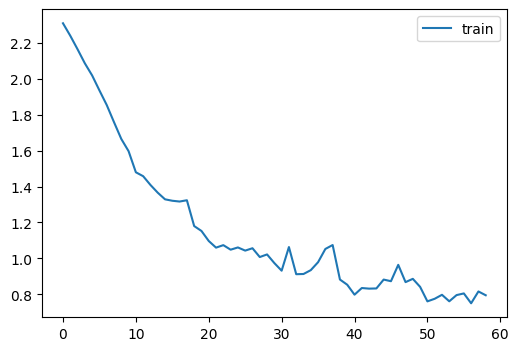

In [38]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## Updated versions since the lesson

Hi there, and welcome to lesson 16, where we are working on building our first flexible trading framework, the learner. And I've got some very good news, which is that I have thought of a way of doing it a little bit more gradually and simply actually than last time. So that should that should make things a bit easier. So we're going to take it a bit more step by step. So we're working in the 9 learner notebook today and we've seen already this, this basic callbacks learner And so the idea is that this learner, all right, this is why we saw no, we've seen so far this learner, which wasn't flexible at all, but it had all the basic pieces, which is we've got a fit method. We had coding that we can only calculate accuracy and average loss. We're had coding, we're putting things on a default device, hard coding, a single learning rate. But the basic idea is here we go through each epoch and call one epoch to to train or evaluate depending on this flag, and then we loop through each batch and the dataloader and one batch is going to grab the x and y parts of the batch, call the model, call the loss function. And if we're training, do the backward pass and then print out well, calculate the statistics for our accuracy and then at the end of the epoch, print that out. So it wasn't very flexible, but it did do something. So that's good. So what we're going to do now is we're going to do as an intermediate step, we're going to look at a but I'm calling a basic callback, learner, And it actually has nearly all the functionality of the full thing, the way we're going to after we look at this basic callback learner, we're then going to after creating some callbacks and metrics, we're going to look at something called the Flexible learner So let's go step by step. So the basic callbacks,learner looks very similar to the previous. learner It, it's got a fit function which is going to go through each epoch calling one epoch with training on and then training off, and then one epoch. We'll go through each batch and call one batch and one batch will call the model the loss function. And if we're training, it will do the backward step. So that's all pretty similar. But there's a few more things going on here. For example, if we have a look at fit, you'll see that after creating the optimizer, so called self.opt_func. So opt func here defaults to SGD. So we instantiate an object passing in our models parameters and the requested learning rate. And then before we start looping through one epoch at a time. Now we've set epochs here. We first of all call self.callback and passing in before fit. Now what does that do? Self.callback is here and it takes a method name. So in this case it's before fit and it calls a function called run callbacks. It passes in a list of our callbacks and the method name in this case before fit. So Run callbacks is something that's going to go for each callback and it's going to sort them in order of their order attribute. And so there's a base class of callbacks which has an order of zero. So our callbacks are all going to have the same order of zero in which you ask otherwise. So here's an example of a callback. So before we look at how callbacks work, let's just let's just run a callback so we can create a ridiculously simple callback code completion callback, which before we start fitting a new 


After the lesson we noticed that `contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`. Therefore we've replaced the context manager with a decorator in this updated version of `Learner`. We have also added a few more callbacks in `one_epoch()`.

In [39]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [40]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.616,1.168,0,train
0.719,0.789,0,eval


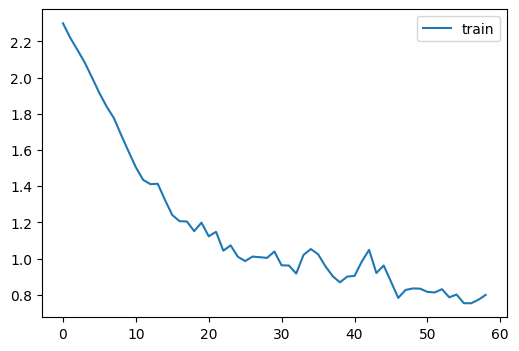

In [41]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## TrainLearner and MomentumLearner

In [42]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [43]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.676,0.936,0,train
0.791,0.585,0,eval


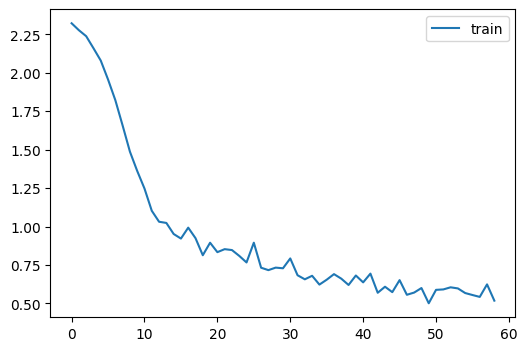

In [44]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## LRFinderCB

In [45]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

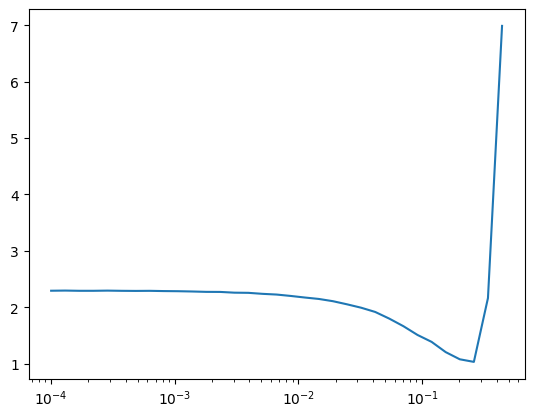

In [46]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [47]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

In [48]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

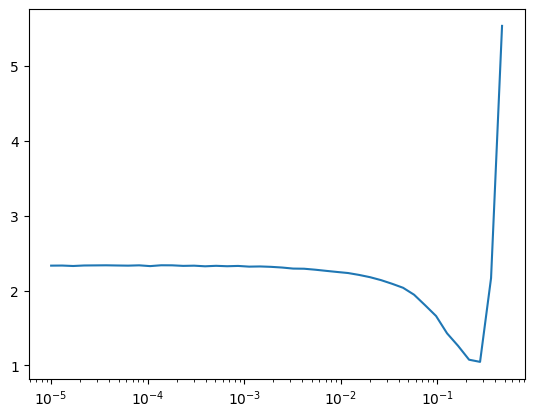

In [49]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [50]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

`lr_find` was added in lesson 18. It's just a shorter way of using `LRFinderCB`.

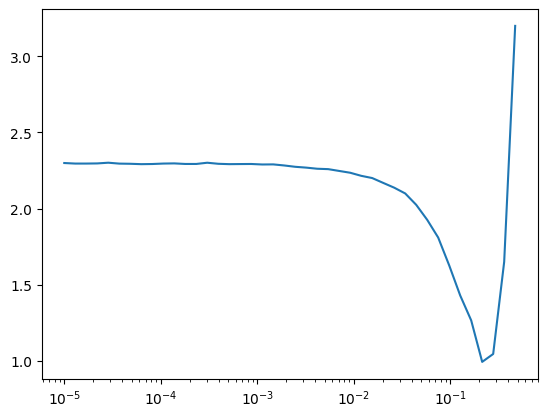

In [51]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()